In [1]:
!pip install git+https://github.com/forrestbao/pyeeg.git
import numpy as np
import pyeeg as pe
import pickle as pickle
import pandas as pd
import math

from sklearn import svm
from sklearn.preprocessing import normalize

import os
import time

  Cloning https://github.com/forrestbao/pyeeg.git to /tmp/pip-req-build-ziye7i6l
  Running command git clone --filter=blob:none --quiet https://github.com/forrestbao/pyeeg.git /tmp/pip-req-build-ziye7i6l
  Resolved https://github.com/forrestbao/pyeeg.git to commit a6c18bb093e4748f9d9c208535a6ae024a0802b8
  Preparing metadata (setup.py) ... done
  Created wheel for pyeeg: filename=pyeeg-0.4.4-py2.py3-none-any.whl size=28111 sha256=198447002397e2b5db13a57825427b63e44c8e98c1f81a169a8e5d385e35b80f
  Stored in directory: /tmp/pip-ephem-wheel-cache-ks0a7u1i/wheels/a8/c4/1a/cee09dcc12a11620066d35ace42e3c1e3bfbcc1db3a0ce7788
Successfully built pyeeg


In [2]:
import pandas as pd
import keras.backend as K
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical 
from keras.layers import Flatten
from keras.layers import Dense
import numpy as np
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras import backend as K
from keras.models import Model
import timeit
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD
#import cv2, numpy as np
import warnings
warnings.filterwarnings('ignore')

In [3]:
channel = [1,2,3,4,7,11,13,17,19,20,21,25,29,31] #14 Channels chosen to fit Emotiv Epoch+
band = [4,8,12,16,30,45] #5 bands
window_size = 256 #Averaging band power of 2 sec
step_size = 16 #Each 0.125 sec update once
sample_rate = 128 #Sampling rate of 128 Hz
subjectList = [
    '01','02','03','04','05','06','07','08','09','10'
    ,'11','12','13','14','15','16','17','18','19','20'
    ,'21','22','23','24','25','26','27','28','29','30'
    ,'31','32'
]
#List of subjects

In [4]:
def label_mapping(valence, arousal):
    # HVHA, HVLA, LVHA, and LVLA
    
    if (valence > 5 and arousal > 5):
        label = 0 #'HVHA'
    elif (valence > 5 and arousal <= 5):
        label = 1 #'HVLA'
    elif (valence <= 5 and arousal > 5):
        label = 2 #'LVHA'
    elif (valence <= 5 and arousal <= 5):
        label = 3 #'LVLA'
    
    return label

def map_label(label):
    new_label = label_mapping(label[0], label[1]) 
    return new_label

In [5]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/EDA_DEAP.ipynb
/kaggle/input/data_preprocessed_python/s20.dat
/kaggle/input/data_preprocessed_python/s17.dat
/kaggle/input/data_preprocessed_python/s31.dat
/kaggle/input/data_preprocessed_python/s14.dat
/kaggle/input/data_preprocessed_python/s32.dat
/kaggle/input/data_preprocessed_python/s28.dat
/kaggle/input/data_preprocessed_python/s24.dat
/kaggle/input/data_preprocessed_python/s18.dat
/kaggle/input/data_preprocessed_python/s22.dat
/kaggle/input/data_preprocessed_python/s02.dat
/kaggle/input/data_preprocessed_python/s26.dat
/kaggle/input/data_preprocessed_python/s29.dat
/kaggle/input/data_preprocessed_python/s25.dat
/kaggle/input/data_preprocessed_python/s09.dat
/kaggle/input/data_preprocessed_python/s06.dat
/kaggle/input/data_preprocessed_python/s11.dat
/kaggle/input/data_preprocessed_python/s15.dat
/kaggle/input/data_preprocessed_python/s05.dat
/kaggle/input/data_preprocessed_python/s04.dat
/kaggle/input/data_preprocessed_python/s23.dat
/kaggle/input/data_preprocessed

In [6]:
def FFT_Processing (sub, channel, band, window_size, step_size, sample_rate):
    '''
    arguments:  string subject
                list channel indice
                list band
                int window size for FFT
                int step size for FFT
                int sample rate for FFT
    return:     void
    '''
    meta = []
    with open("/kaggle/input/data_preprocessed_python/s" + sub + '.dat', 'rb') as file:

        subject = pickle.load(file, encoding='latin1') #resolve the python 2 data problem by encoding : latin1

        for i in range (0,40):
            # loop over 0-39 trails
            data = subject["data"][i]
            labels = subject["labels"][i]
            labels = np.array(map_label(labels))
            start = 0;

            while start + window_size < data.shape[1]:
                meta_array = []
                meta_data = [] #meta vector for analysis
                for j in channel:
                    X = data[j][start : start + window_size] #Slice raw data over 2 sec, at interval of 0.125 sec
                    Y = pe.bin_power(X, band, sample_rate) #FFT over 2 sec of channel j, in seq of theta, alpha, low beta, high beta, gamma
                    meta_data = meta_data + list(Y[0])


                meta.append([np.array(meta_data), np.array(labels)])    
                start = start + step_size
                
        meta = np.array(meta, dtype = object)
        np.save('s' + sub, meta, allow_pickle=True, fix_imports=True)

In [7]:
for subjects in subjectList:
    FFT_Processing (subjects, channel, band, window_size, step_size, sample_rate)

In [8]:
data = []
label = []

for subjects in subjectList:

    with open('/kaggle/working/s' + subjects + '.npy', 'rb') as file:
        sub = np.load(file,allow_pickle=True)
        for i in range (0,sub.shape[0]):
            data.append(sub[i][0])
            label.append(sub[i][1])

np.save('data', np.array(data), allow_pickle=True, fix_imports=True)
np.save('label', np.array(label), allow_pickle=True, fix_imports=True)
print("Training datasets:", np.array(data).shape, np.array(label).shape)

Training datasets: (624640, 70) (624640,)


In [9]:
with open('/kaggle/working/data.npy', 'rb') as fileTrain:
    data  = np.load(fileTrain)
    
with open('/kaggle/working/label.npy', 'rb') as fileTrainL:
    label  = np.load(fileTrainL)

In [10]:
from sklearn.model_selection import train_test_split
x_train, x, y_train, y = train_test_split(data, label, test_size=0.4, random_state=42)

In [11]:
x_val, x_test, y_val, y_test = train_test_split(x, y, test_size=0.5, random_state=42)

In [12]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [13]:
np.save('x_train', np.array(x_train), allow_pickle=True, fix_imports=True)
np.save('y_train', np.array(y_train), allow_pickle=True, fix_imports=True)
np.save('x_val', np.array(x_val), allow_pickle=True, fix_imports=True)
np.save('y_val', np.array(y_val), allow_pickle=True, fix_imports=True)
np.save('x_test', np.array(x_test), allow_pickle=True, fix_imports=True)
np.save('y_test', np.array(y_test), allow_pickle=True, fix_imports=True)

In [14]:
with open('/kaggle/working/x_train.npy', 'rb') as file:
    x_train = np.load(file, allow_pickle=True)
with open('/kaggle/working/y_train.npy', 'rb') as file:
    y_train = np.load(file, allow_pickle=True)
with open('/kaggle/working/x_val.npy', 'rb') as file:
    x_val = np.load(file, allow_pickle=True)
with open('/kaggle/working/y_val.npy', 'rb') as file:
    y_val = np.load(file, allow_pickle=True)
with open('/kaggle/working/x_test.npy', 'rb') as file:
    x_test = np.load(file, allow_pickle=True)
with open('/kaggle/working/y_test.npy', 'rb') as file:
    y_test = np.load(file, allow_pickle=True)

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(normalize(x_train))
x_val = scaler.fit_transform(normalize(x_val))
x_test = scaler.fit_transform(normalize(x_test))

In [16]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], 1)
x_val = x_val.reshape(x_val.shape[0],x_test.shape[1],1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [17]:
x_train.shape

(374784, 70, 1)

In [18]:
batch_size = 256
num_classes = 4
epochs = 200
input_shape=(x_train.shape[1], 1)

In [19]:
print(input_shape)

(70, 1)


In [20]:
import tensorflow as tf

In [21]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Using GPU:", tf.test.is_gpu_available())

Num GPUs Available:  1
Using GPU: True


In [22]:
from keras.layers import Conv1D, ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense
from keras.regularizers import l2

In [23]:
model = Sequential()
intput_shape=(x_train.shape[1], 1)
model.add(Conv1D(164, kernel_size=3,padding = 'same',activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
model.add(Conv1D(164,kernel_size=3,padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
model.add(Conv1D(82,kernel_size=3,padding = 'same', activation='relu'))
model.add(MaxPooling1D(pool_size=(2)))
model.add(Flatten())
model.add(Dense(82, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(42, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(21, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 70, 164)        │           656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 70, 164)        │           656 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 35, 164)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 35, 164)        │        80,852 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 35, 164)        │           656 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 17, 164)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 17, 82)         │        40,426 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 8, 82)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 656)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 82)             │        53,874 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 82)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 42)             │         3,486 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 21)             │           903 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 21)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │            88 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 181,597 (709.36 KB)

 Trainable params: 180,941 (706.80 KB)

 Non-trainable params: 656 (2.56 KB)

In [24]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

In [25]:
history=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,  
          verbose=1,validation_data=(x_test,y_test))

Epoch 1/200


I0000 00:00:1734079518.308814     119 service.cc:145] XLA service 0x78afe8001a90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734079518.308871     119 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  27/1464 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.2965 - loss: 1.4533 

I0000 00:00:1734079525.396255     119 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1464/1464 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.3743 - loss: 1.3062 - val_accuracy: 0.4621 - val_loss: 1.1747
Epoch 2/200
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.4583 - loss: 1.1893 - val_accuracy: 0.4955 - val_loss: 1.1138
Epoch 3/200
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.4947 - loss: 1.1304 - val_accuracy: 0.5301 - val_loss: 1.0604
Epoch 4/200
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.5211 - loss: 1.0837 - val_accuracy: 0.5469 - val_loss: 1.0195
Epoch 5/200
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.5415 - loss: 1.0450 - val_accuracy: 0.5641 - val_loss: 0.9944
Epoch 6/200
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.5589 - loss: 1.0126 - val_accuracy: 0.5818 - val_loss: 0.9631
Epoch 7/200
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.5745 - loss: 0.9864 - val_accuracy: 0.5905 - val_loss: 0.9448
Epoch 8/200
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.5872 - loss: 0.9613 - val

In [26]:
score = model.evaluate(x_train, y_train, verbose=1)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

11712/11712 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step - accuracy: 0.8088 - loss: 0.4806
Train loss: 0.48163720965385437
Train accuracy: 0.8082655668258667


In [27]:
score = model.evaluate(x_val, y_val, verbose=1)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

3904/3904 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.7301 - loss: 0.6948
Val loss: 0.6976262331008911
Val accuracy: 0.7284516096115112


In [28]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

3904/3904 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7277 - loss: 0.6955
Test loss: 0.696373701095581
Test accuracy: 0.7280913591384888


In [29]:
# list all data in history
print(history.history.keys())
import matplotlib.pyplot as plt
import numpy


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


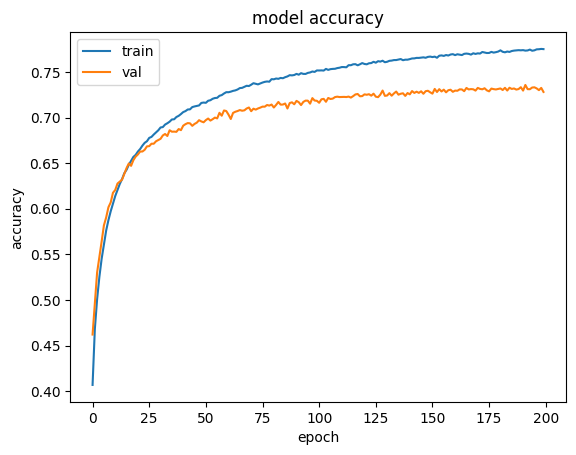

In [30]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

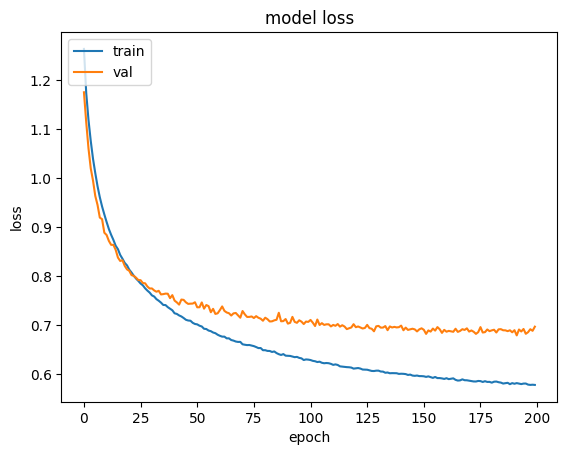

In [31]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [32]:
from sklearn.metrics import confusion_matrix,classification_report
import numpy as np
import seaborn as sns

3904/3904 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


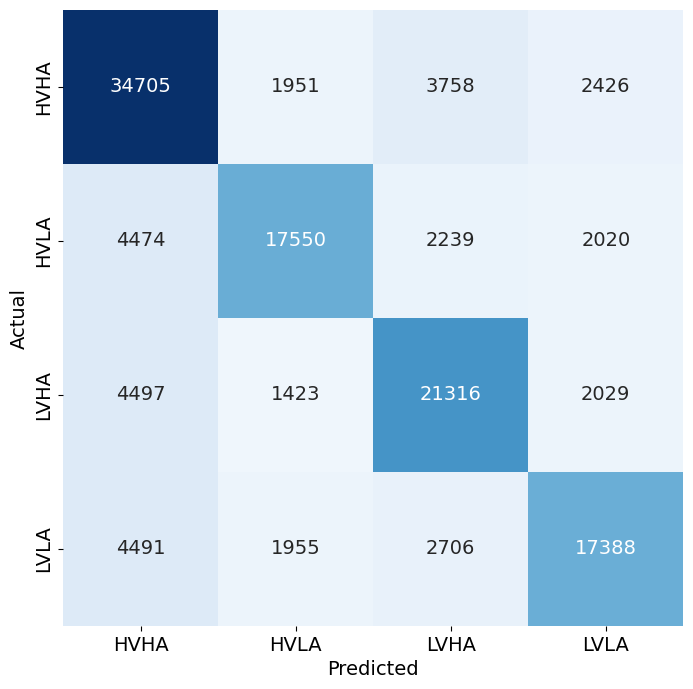

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.72      0.81      0.76     42840
           1       0.77      0.67      0.71     26283
           2       0.71      0.73      0.72     29265
           3       0.73      0.66      0.69     26540

    accuracy                           0.73    124928
   macro avg       0.73      0.72      0.72    124928
weighted avg       0.73      0.73      0.73    124928



In [33]:
class_names = ['HVHA', 'HVLA', 'LVHA', 'LVLA']

y_pred = model.predict(x_test)

y_predict = []

for i in range(len(y_pred)):
    y_predict.append(np.argmax(y_pred[i]))

y_predict = np.array(y_predict)
yt_test = np.argmax(y_test, axis=1)

cm = confusion_matrix(yt_test, y_predict)
clr = classification_report(yt_test, y_predict)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues', annot_kws={"size":14})
plt.xticks(np.arange(4) + 0.5, class_names, fontsize=14)
plt.yticks(np.arange(4) + 0.5, class_names, fontsize=14)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("Actual", fontsize=14)
# plt.title("Confusion Matrix for GRU Model")
plt.show()

print("Classification Report:\n----------------------\n", clr)